# Patrones de difracción y Celdas unitarias

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import json

In [2]:
#%matplotlib notebook
%matplotlib inline

In [3]:
def Ejes (A, B, C, AB, BC, AC):
    '''
    Genera un Array de tres vectores X, Y, Z con módulo A, B, C y 
    ángulos entre ellos AB, BC, AC (en radianes).
    Fija la libertad de variables tomando X=(A1,0,0) y Y=(B1,B2,0)
    (Las expresiones salen de resolver las ecuaciones de producto punto entre los 3 vectores)
    '''
    p, q, r = np.around(A*B*np.cos(AB),4), np.around(B*C*np.cos(BC),4), np.around(A*C*np.cos(AC),4)
    X = np.array([A,0,0])
    Y = np.array([p/A, np.sqrt(B**2-p**2/A**2),0])
    Z = np.array([r/A, (q-p*r/A**2)/Y[1], np.sqrt(C**2-((q-p*r/A**2)/Y[1])**2-(r/A)**2)])
    return np.array([X,Y,Z])

In [4]:
class Red(object):
    """Clase que representa una red (retícula)
    
    Esencialmente, es un arreglo de tres vectores. Se asume que las unidades son Angstrom.
    
    """
    
    # Las clases tienen instancias y métodos.
    # El primer método que se necesita es un inicializador
    def __init__(self, a1, a2, a3):
        """
        Crear una red a partir de tres vectores. Se asume que las unidades son Angstrom.
        
        Argumentos:
          a1, a2, a3 -> vectores (arreglos de numpy)
        """
        m = np.array([a1,a2,a3], dtype=np.float64).reshape((3, 3))
        lengths = np.sqrt(np.sum(m ** 2, axis=1))
        angles = np.zeros(3)
        for i in range(3):
            j = (i + 1) % 3
            k = (i + 2) % 3
            angles[i] = np.dot(m[j], m[k]) / (lengths[j] * lengths[k])
            
        # Los siguientes son atributos de la clase.
        # De forma convencional, el guión bajo se usa cuando no se espera que el usuario use estos atributos
        self._angles = np.arccos(angles) * 180. / np.pi
        self._lengths = lengths
        self._matrix = m
        self._a1 = np.array(a1)
        self._a2 = np.array(a2)
        self._a3 = np.array(a3)
        
    # Luego se pueden implementar propiedades 
    
    @property
    def angles(self):
        """
        Ángulos (alpha, beta, gamma) de la red.
        """
        return tuple(self._angles)

    @property
    def a(self):
        """
        Parámetro de red a
        """
        return self._lengths[0]

    @property
    def b(self):
        """
        Parámetro de red b
        """
        return self._lengths[1]

    @property
    def c(self):
        """
        Parámetro de red c
        """
        return self._lengths[2]

    @property
    def abc(self):
        """
        Longitudes de los vectores de red, i.e. (a, b, c)
        """
        return tuple(self._lengths)
        
    # También se pueden implementar métodos.
    
    def plot (self,ax):
        """
        Incluye los vectores de red en el gráfico ax
        
        Argumentos:
            ax -> un eje con proyección 3d
        """
        Axes3D.plot3D(ax,[0,self._a1[0]],[0,self._a1[1]],[0,self._a1[2]],'k')
        Axes3D.plot3D(ax,[0,self._a2[0]],[0,self._a2[1]],[0,self._a2[2]],'k')
        Axes3D.plot3D(ax,[0,self._a3[0]],[0,self._a3[1]],[0,self._a3[2]],'k')
        Axes3D.grid(ax,False)
        
    def get_supercell(self, repetitions, with_plot=False, ax=None,centered =False):
        """
        Construye supercelda según la lista de enteros en repetitions
        """
        if centered:
            repx = repetitions[0]
            repy = repetitions[1]
            repz = repetitions[2]
        
            pts = np.zeros([(2*repx+1)*(2*repy+1)*(2*repz+1),3])
            ctr = 0
            for ix in range(-repx, repx+1):
                for iy in range(-repy, repy+1):
                    for iz in range(-repz, repz+1):
                        pts[ctr,:]= ix*self._a1+iy*self._a2 +iz*self._a3 
                        ctr+=1
        else:
            repx = repetitions[0]
            repy = repetitions[1]
            repz = repetitions[2]
        
            pts = np.zeros([(repx+1)*(repy+1)*(repz+1),3])
            ctr = 0
            for ix in range(repx+1):
                for iy in range(repy+1):
                    for iz in range(repz+1):
                        pts[ctr,:]= ix*self._a1+iy*self._a2 +iz*self._a3 
                        ctr+=1
        
        if with_plot:
            self.plot_supercell(ax,pts)
        
        return pts
        
    def plot_supercell (self,ax, pts):
        """
        Incluye los vectores de red en el gráfico ax
        
        Argumentos:
            ax -> un eje con proyección 3d
        """
        npts=np.shape(pts)[0]
        for i in range(npts):
            ax.scatter(pts[i,0],pts[i,1],pts[i,2], c='0.55', s=20)
            
        
        
        
    def get_wigner_seitz (self, plot=False, ax=None):
        """
        Construye la celda de Wigner Seitz
        
        Regresa los vértices
        """
        #forma sencilla (usando hint de Raúl)
        from scipy.spatial import Voronoi, voronoi_plot_2d

        pts = self.get_supercell([1,1,1], centered = True)
        
        v = Voronoi(pts)
        idx = -1
        for i in range(len(v.regions)):
            try:
                if v.regions[i][0] >= 0 :
                    idx = i
            except:
                print ('no elements')
        
        if idx < 0 :
            print ('No se pudo encontrar la celda de WS')
        else:
            ver = v.vertices[v.regions[idx]]
        
        if plot:
            max_length=1.1*np.max(self.abc)
            nats = len(ver)
            coords = ver
            d0 = []
            for iat in range(nats):
                for jat in range(iat,nats):
                    dist = np.linalg.norm(coords[jat,:]-coords[iat,:])
                    if dist > 0:
                        d0.append(dist)
            d0 =np.array(d0)
    
            max_length = 0.68*np.average(d0)
            #max_length = 0.64*np.average(d0) #Para Brillouin FCC
    
            for iat in range(nats):
                for jat in range(iat,nats):
                    dist = np.linalg.norm(coords[jat,:]-coords[iat,:])
                    if (dist <= max_length):
                        Axes3D.plot3D(ax,[coords[iat,0],coords[jat,0]],[coords[iat,1],coords[jat,1]]
                                      ,[coords[iat,2],coords[jat,2]],'g--')
        
        return ver

In [5]:
class Base_atomica (object):
    """
    Clase que determina la base atómica de un cristal con base en una lista de coordenadas y una lista de elementos
    """
    # Las clases tienen instancias y métodos.
    # El primer método que se necesita es un inicializador
    def __init__(self, coords, elements, coords_relative=True):
        """
        Crear una base atómica a partir de una lista de coordenadas y de átomos 
        Se asume por ausencia que las posiciones están dadas en coordenadas relativas
        
        Argumentos:
          coords -> arreglo de coordenadas (vectores)
          elements -> lista de elementos
          coords_relative -> BOOL (True por descarte)
        """
        coor = np.array(coords, dtype=np.float64)
        
        nats = np.shape(coor)[0]
        if ( len(elements) != nats):
            print ('Error: El número de elemntos y el número de átomos (coordenadas) debe ser el mismo')
                   
        self.coords = coor
        self.elements = elements
        self.nats = nats
        self.relative = coords_relative
        
    def son_relativas(self):
        return self.relative
    
    def get_number_of_atoms(self):
        return self.nats
    
    def plot(self, ax):
        nats = self.nats
        for i in range(self.nats):
            ax.scatter(self.coords[i,0],self.coords[i,1],self.coords[i,2], c='b', s=60)
        

In [22]:
class Cristal(object):
    """
    Clase que determina un cristal con base en una red y una base atómica
    """
    # Las clases tienen instancias y métodos.
    # El primer método que se necesita es un inicializador
    def __init__(self,red,base):
        """
        Crear un cristal a partir de una red y una base atómica
        
        Argumentos:
          red -> Instancia de la clase Red
          base -> Instancia de la clase Base_atomica
        """
        if type(red) != Red:
            print ('Error: debes especificar un objeto Red como entrada')
        if type(base) != Base_atomica:
            print ('Error: debes especificar un objeto Base_atomica como entrada')
        
        if base.son_relativas():
            coords = base.coords
        else:
            coords = np.zeros((base.nats,3))
            for i in range(3):
                coords[:,i] = base.coords[:,i]/red.abc[i]
        
        self.cart_coords = np.zeros((base.nats,3))
        
        for i in range(base.nats):
            self.cart_coords[i,:] = coords[i,0]*red._a1 + coords[i,1]*red._a2+coords[i,2]*red._a3
            
        self.relative = coords
        self.base = Base_atomica(coords, base.elements)
        self.red = Red (red._a1,red._a2,red._a3)
        self.reciprocal = 2*np.pi*(np.linalg.inv(red._matrix)).T
        
        with open("./periodic_table.json", "rt") as f:
            pt_data = json.load(f)
        Z = []
        for i in range(len(base.elements)):
            Z.append(pt_data[base.elements[i]]['Atomic no'])
        self.Z = Z
        
        
        
    def plot(self,ax,max_length=2.0):
        base_cart = Base_atomica(self.cart_coords, self.base.elements)
        base_cart.plot(ax)
        self.red.plot(ax)
        self.dibuja_enlaces(ax,max_length=max_length)
        
    def dibuja_enlaces(self,ax, max_length=2.0):
        #max_length=0.5*self.red.a
        nats = self.base.nats
        coords = self.cart_coords
        for iat in range(nats):
            for jat in range(iat,nats):
                dist = np.linalg.norm(coords[jat,:]-coords[iat,:])
                if (dist <= max_length):
                    Axes3D.plot3D(ax,[coords[iat,0],coords[jat,0]],[coords[iat,1],coords[jat,1]]
                                  ,[coords[iat,2],coords[jat,2]],'r')
    
    def get_supercell(self,rep):
        pts = self.red.get_supercell(rep)
        cart_coords = self.cart_coords
        new_coords = []
        new_specs = []
        for i  in range(len(pts)):
            for iat in range(self.base.nats):
                new_coords.append(cart_coords[iat,:]+pts[i,:])
                new_specs.append(self.base.elements[iat])
        
        a1 = rep[0]*self.red._a1
        a2 = rep[1]*self.red._a2
        a3 = rep[2]*self.red._a3
          
        newred = Red(a1,a2,a3)
        newbase = Base_atomica(new_coords,new_specs,coords_relative=False)
        newcristal = Cristal(newred,newbase)
        return newcristal
    
    
    def get_reciprocal(self):
        return self.reciprocal
        
    def get_brillouin_zone(self, with_plot=False, ax=None):
        rec = Red(self.reciprocal[0,:],self.reciprocal[1,:],self.reciprocal[2,:])
        if with_plot:
            bz = rec.get_wigner_seitz(plot=True, ax=ax)
        else:
            bz = rec.get_wigner_seitz()
        return bz
    

    def get_atoms_WS(self, with_plot = False, ax=None):
        """
        Aquí se sigue la definición de la primera celda de Wigner Seitz que contiene
        el conjunto de puntos que están más cerca al origen que a cualquier otro punto de la red
        """
        pts = self.red.get_supercell([2,2,2], centered = True)
        cart_coords = self.cart_coords
        new_coords = []
        new_specs = []
        for i  in range(len(pts)):
            for iat in range(self.base.nats):
                new_coords.append(cart_coords[iat,:]+pts[i,:])
                new_specs.append(self.base.elements[iat])
        
        new_coords = np.array(new_coords)
        nats = np.shape(new_coords)[0]
        if with_plot:
            ver_ws = self.red.get_wigner_seitz(plot=True, ax=ax)
        else:    
            ver_ws = self.red.get_wigner_seitz()
        d0 = 0.
        for iver in range(len(ver_ws)):
            if np.linalg.norm(ver_ws[iver,:]) > d0 :
                d0 = np.linalg.norm(ver_ws[iver,:])
        #print d0
        at_ws =[]
        for iat in range(nats):
            dist = np.linalg.norm( new_coords[iat,:])
            if dist <= d0*1.2:
                at_ws.append(new_coords[iat,:])
                if with_plot :
                    ax.scatter(new_coords[iat,0],new_coords[iat,1],new_coords[iat,2], c='b', s=60)
        
        return at_ws  
    
    def Vc(self):
        '''
        Calcula el volúmen de la celda unitaria en m^3, asumiendo que los parámetros de red están en Angstrom
        '''
        return np.linalg.det(self.red._matrix)*10**(-30) #m^3
    
    def T_Debye(self, Vs):
        '''
        Calcula la temperatura de Debye (Kelvin) para la velocidad del sonido Vs (m/s) asumiendo que los parámetros
        de red están en Ansgtrom.
        T_D =  (h Vs/k_B)*(6*pi^2/Vc)^(1/3) con Vc volúmen de celda unitaria
        '''
        Vc = self.Vc() #m^3
        kB = 1.38064852E-23 #J/K
        h = 1.054571817E-34 #J*s, es h barra
        return (h*Vs/kB)*(6*np.pi**2/Vc)**(1/3)

### Germanio

In [23]:
ejes = Ejes (4.075, 4.075, 4.075, 60*np.pi/180, 60*np.pi/180, 60*np.pi/180) #Ejes en unidades de Ansgtrom
base = Base_atomica ([[0.125,0.125,0.125],[0.875,0.875,0.875]],2*['Ge'])
red =  Red(*ejes)
Germanio = Cristal(red, base)

In [ ]:
### 3/vo^3 = 1/vta^3 +1/vtb^3 +1/vl^3 para 2 ondas transversales y una longitudinal, vo el promedio

In [34]:
vta = 5.62E3
vtb = 5.46E3
vl = 4.97E3
Vs = (3/(1/vta**3+1/vtb**3+1/vl**3))**(1/3)
#Vs = 5400 #m/s, Wikipedia
ThetaD = Germanio.T_Debye(Vs) #Kittel dice que debería ser 374 K
print(Vs)
print(ThetaD)
print('Error de ' +str(100*(ThetaD-374)/374))

5320.129239270292
436.29084466713596
Error de 16.655306060731537


In [28]:
def gaussxw(N):

    #Aproximación inicial de las raíces de los polinomios de Legendre
    a = np.linspace(3,4*N-1,N)/(4*N+2)
    x = np.cos(np.pi*a+1/(8*N*N*np.tan(a)))

        # Encontramos ceros de Legendre con Newton-Raphson
    epsilon = 1e-15
    delta = 1.0
    while delta>epsilon:
        p0 = np.ones(N,float)
        p1 = np.copy(x)
        for k in range(1,N):
            p0,p1 = p1,((2*k+1)*x*p1-k*p0)/(k+1)
        dp = (N+1)*(p0-x*p1)/(1-x*x)
        dx = p1/dp
        x -= dx
        delta = max(abs(dx))

    # Calculando los pesos
    w = 2*(N+1)*(N+1)/(N*N*(1-x*x)*dp*dp)
    return x,w

In [29]:
rho = 2/Germanio.Vc() #m^-3, dos átomos por celda unitaria
V = 100E-6 #m^3, V = 100cm^3
kB = 1.38064852E-23 #J/K

N = 50 #Orden de la cuadratura gaussiana
x,w = gaussxw(N)

def f(x):
    return x**4*np.exp(x)/(np.exp(x)-1)**2

def Cv(T):
    '''
    Calcula 
    '''
    a = 0.0
    b = ThetaD/T

    xp = 0.5*(b-a)*x + 0.5*(b+a)
    wp = 0.5*(b-a)*w
    
    # Hacemos la integral
    s = 0.0
    for k in range(N):
        s += wp[k]*f(xp[k])
    
    #return 9*V*rho*kB*(T/ThetaD)**3*s si le metemos volúmen
    return 9*rho*V*kB*(T/ThetaD)**3*s

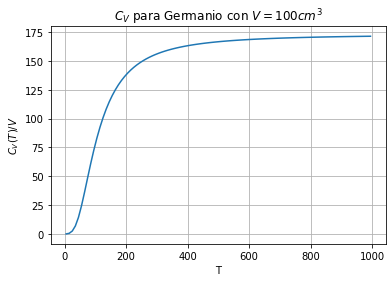

In [30]:
T = np.arange(5,1000,10)
Y = []
for t in T:
    Y.append(Cv(t))

plt.plot(T,np.array(Y))

plt.xlabel(r'T')
plt.ylabel(r'$C_V(T)/V$')
plt.title(r'$C_{V}$ para Germanio con $V = 100cm^3$')
plt.grid(True)
plt.show()